# Import The Needed Libraries

In [28]:
import os # navigate through folders
import matplotlib.pyplot as plt
import random
from PIL import Image # help working in images
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models, regularizers
from sklearn.metrics import  classification_report, confusion_matrix

# Load the Data

In [3]:
# Load data & Define paths
data = r"C:\Users\user\Desktop\ChestXrayproject\data"

train_dir = os.path.join(data, "train") 
val_dir   = os.path.join(data, "val")
test_dir  = os.path.join(data, "test")


# Exploring Data 

In [4]:
# Exploring Data (balanced or not)
for folder in ["test", "train", "val"]:
    for category in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(data, folder, category)
        print(f"{folder}/{category} : {len(os.listdir(path))} images")

test/NORMAL : 234 images
test/PNEUMONIA : 390 images
train/NORMAL : 1341 images
train/PNEUMONIA : 3875 images
val/NORMAL : 8 images
val/PNEUMONIA : 8 images


**In the training set, Pneumonia cases dominate.**

-If I train directly without any intervention to solve the imbalance data, the model may just “learn” to predict PNEUMONIA most of the time and still get high accuracy.

**Tiny validation set**

-Only 8 + 8 images is too small to judge performance properly.
as a solution for that i can merge validation with training and instead use part of training as validation.


**Good test set size**

-624 images total (234 + 390) That’s decent for final evaluation.



# Visualization

In [7]:
splits = ["train", "val", "test"]
categories = ["NORMAL", "PNEUMONIA"]



### Visualizing Random Image

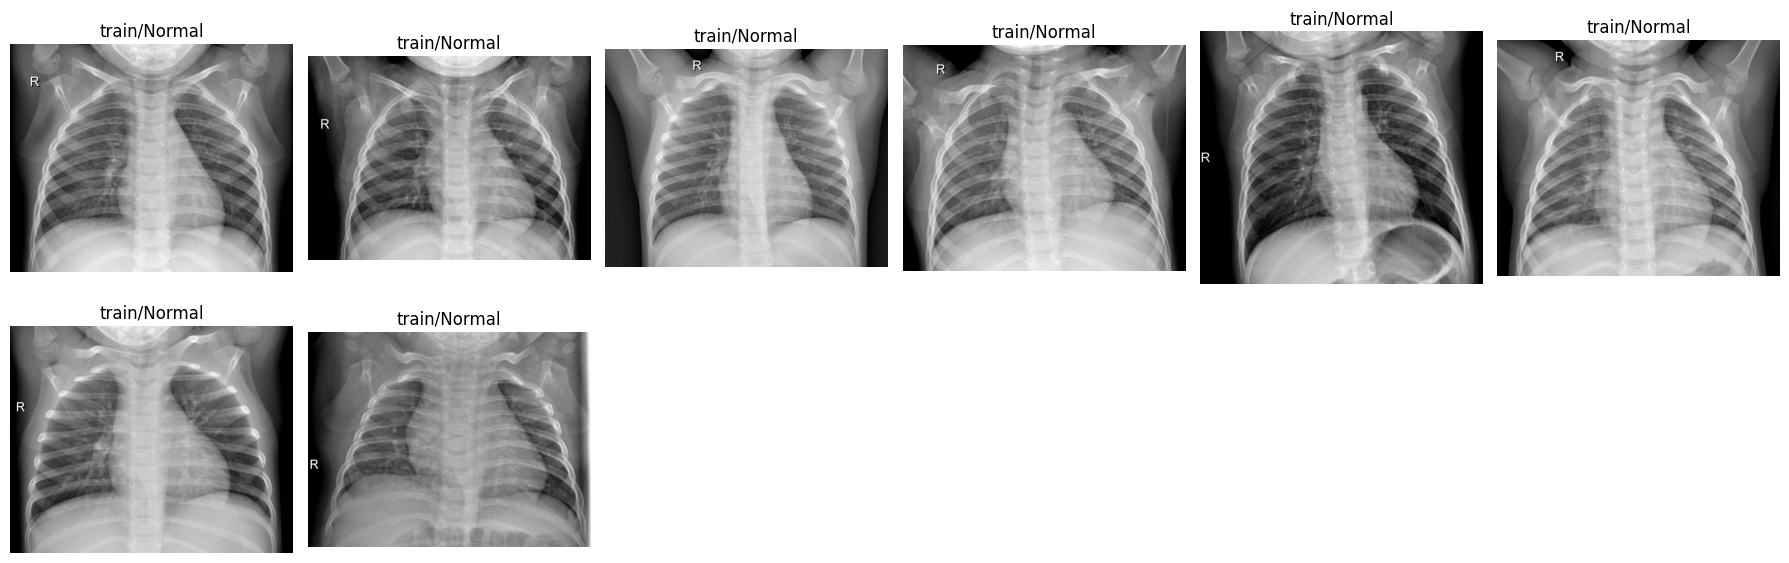

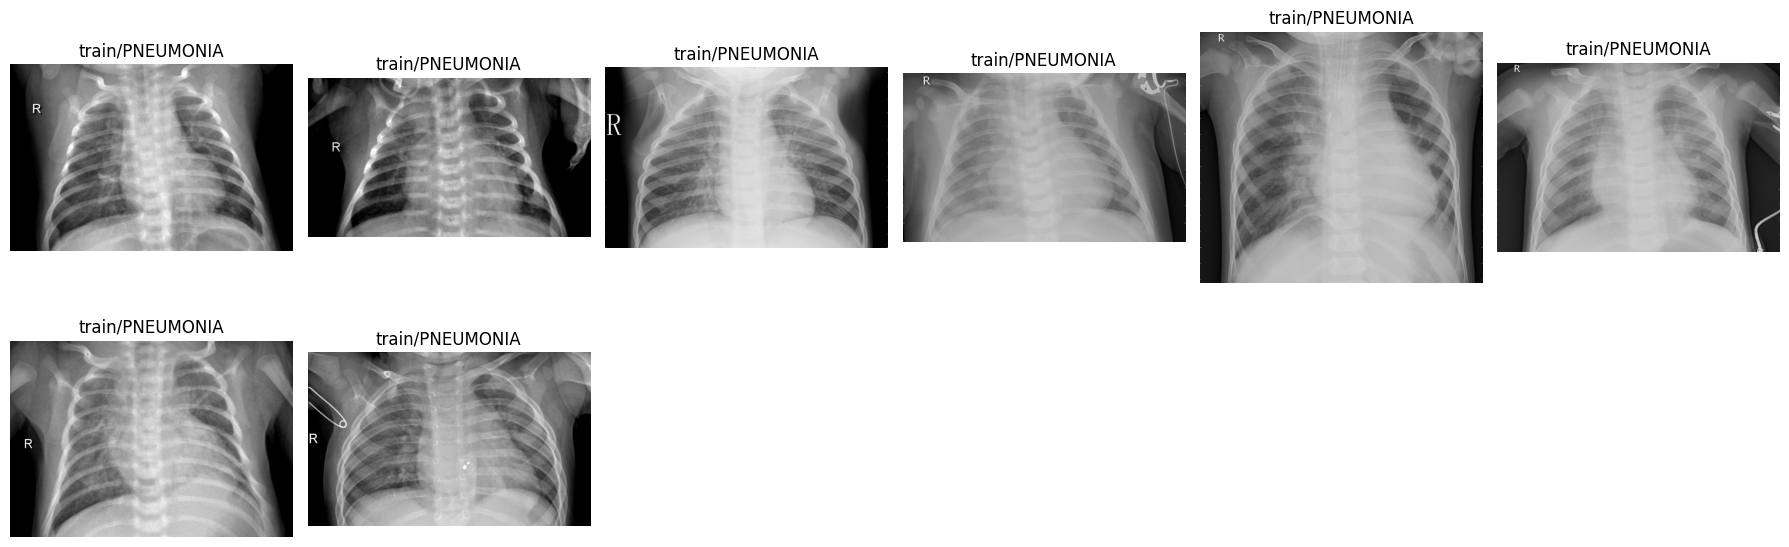

In [5]:
def show_random_image(splits, categories, n= 6, seed=42):
    folder = os.path.join(data, splits, categories)
    files= os.listdir(folder) # list of all images in the folder
    random.Random(seed).shuffle(files)
    picks = files[:n]  # pick n random images

    cols = min(n,6) #
    rows = (n+cols-1)//cols

    plt.figure(figsize=(3*cols, 3*rows))
    for i, fname in enumerate(picks,1):
        img_path = os.path.join(folder, fname) # create full path to image
        img = Image.open(img_path).convert("L")# convert to grayscale
        plt.subplot(rows,cols,i)
        plt.imshow(img, cmap="gray") 
        plt.title(f"{splits}/{categories}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_image("train", "Normal", n=8)
show_random_image("train", "PNEUMONIA", n=8)

From the images above, we can observe the difference between healthy and infected lungs. In the X-ray of normal lungs, the lung fields appear clear and dark, while in pneumonia cases, the lungs show white, patchy infiltrates indicating infection.

### Class Distribution

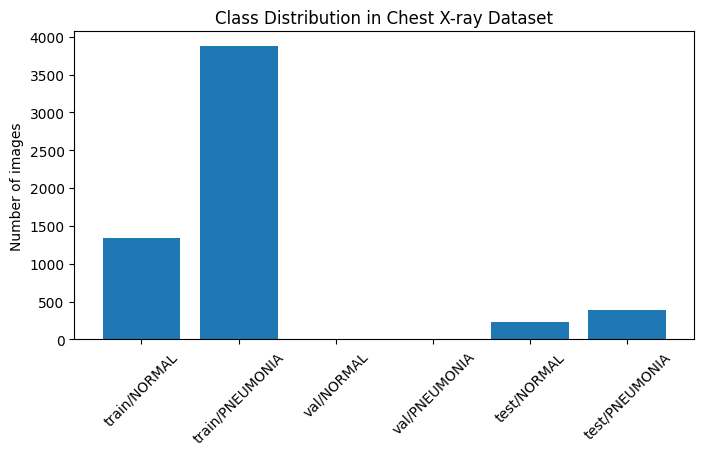

In [37]:
counts = {}
for split in splits:
    for category in categories:
        counts[(split,category)] = len(os.listdir(os.path.join(data, split, category))) # count images

# Bar Chart
labels = [f"{s}/{k}" for s in splits for k in categories] # create labels for x-axis ex : train/NORMAL
values = [counts[(s,k)] for s in splits for k in categories] # get counts in the same order as labels

plt.figure(figsize=(8,4))
plt.bar(labels, values)
plt.ylabel("Number of images")
plt.xticks(rotation=45)
plt.title("Class Distribution in Chest X-ray Dataset")
plt.show()


this confirms the earlier observation in the notebook: the training set has  class imbalance. If no corrective measures are taken, the model will likely become biased toward predicting PNEUMONIA

### Image Size

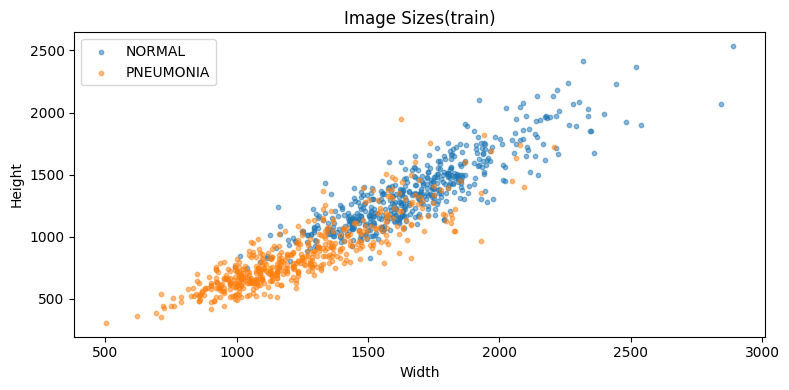

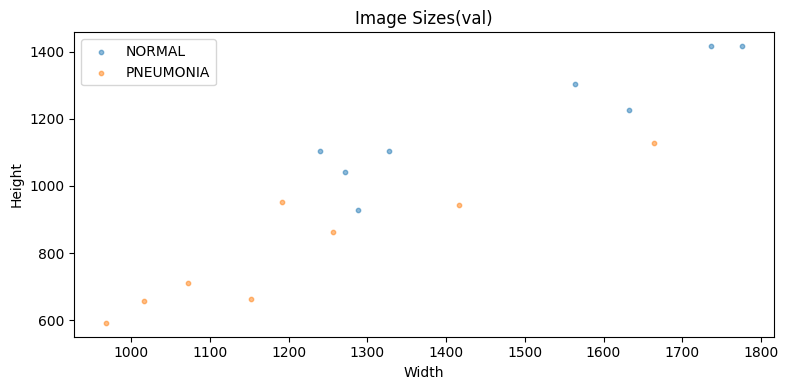

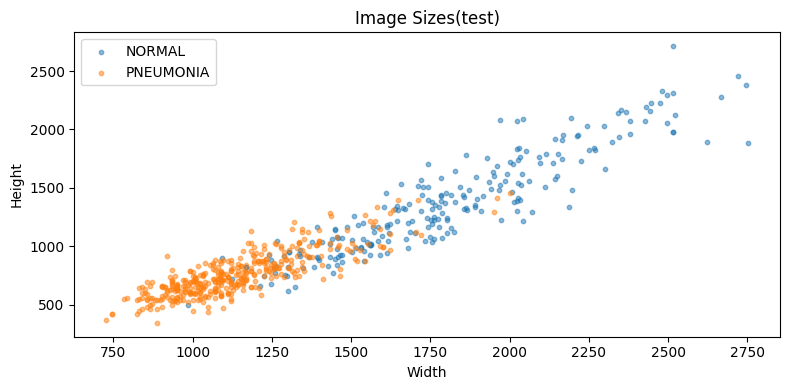

In [8]:
# get size from a folder
def get_sizes(splits, categories, max_images=500):
    folder = os.path.join(data, splits, categories)
    files = os.listdir(folder)[:max_images]  # list of all images in the folder
    return [Image.open(os.path.join(folder, f)).size for f in files]



# collect sizes
sizes = {}
for split in splits:
    for category in categories:
        sizes[(split,category)] = get_sizes(split, category) 


# Scatter plot of image sizes
for split in splits:
    plt.figure(figsize=(8,4))
    for category in categories:
        w, h = zip(*sizes[(split,category)])
        plt.scatter(w, h, alpha=0.5, s=10, label=category)
    plt.title(f"Image Sizes({split})")
    plt.xlabel("Width");plt.ylabel("Height")
    plt.legend(); plt.tight_layout()
    plt.show()


The dataset contains images of varying sizes, which can negatively impact deep learning models since they require a consistent input shape. To address this, all images must be resized to a fixed target size (e.g., 150×150, 224×224, or 299×299) in my case i will go with 224x224. Without resizing, the model will not be able to process images in uniform batches. Additionally, standardizing image sizes helps eliminate potential bias caused by one class having systematically higher resolutions than the other

### Pixels Intensiy Distrebution

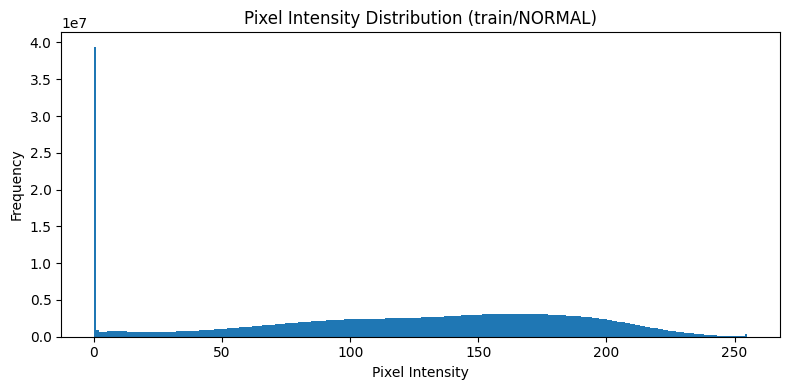

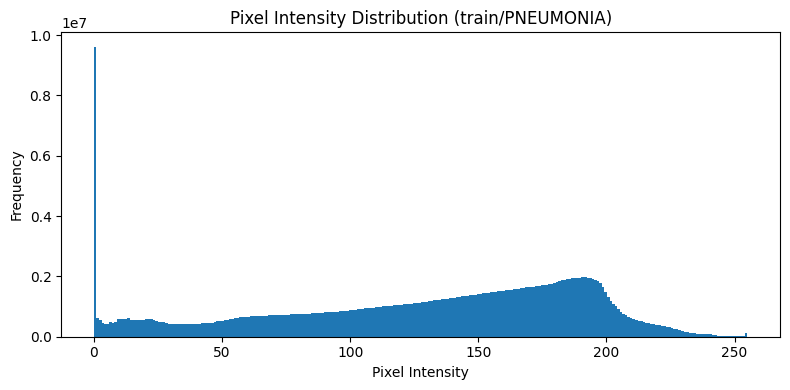

In [9]:
def pixels_hist(splits,categories, sample=200):
    folder= os.path.join(data, splits, categories)
    files = os.listdir(folder)
    random.shuffle(files)
    files= files[:sample] # take a sample of files

    values = []
    for fname in files:
        img_path = os.path.join(folder, fname)
        with Image.open(img_path).convert("L") as img:
         arr = np.array(img, dtype = np.uint8).ravel() # flatten the image to 1D array
         values.append(arr)
    values = np.concatenate(values)# flatten the list of arrays into a single array
    plt.figure(figsize=(8,4))
    plt.hist(values, bins=256, range=(0,255))
    plt.title(f"Pixel Intensity Distribution ({splits}/{categories})")
    plt.xlabel("Pixel Intensity"); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


pixels_hist("train", "NORMAL")
pixels_hist("train", "PNEUMONIA")

The pixel intensity distribution of the dataset shows that most X-ray images contain a large proportion of dark background regions (very low intensity values) along with useful medical details spread across midrange intensities. This is typical for chest X-rays, where the background is black and the lung structures fall in the gray spectrum.

The analysis confirms that:

Normalization is required to scale values into a consistent range ( 0–1), which helps stabilize training and improves model learning.

# Data Pre Processing

    1) Resize images (e.g., 224x224) also we can try (150x150)

    2)Normalize pixel values
    
    3)Apply data augmentation to balance the dataset and prevent overfitting

###  Resize Images 

In [10]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32 # how many images to process at a time
SEED = 42 

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels = "inferred",# read labels from folder names
    label_mode = "binary",  # two classes 0/1
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=val_dir,
    labels = "inferred",
    label_mode = "binary",  
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)


test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels = "inferred",# read labels from folder names
    label_mode = "binary",  # two classes 0/1
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

class_name = train_ds.class_names
print(class_name)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']


In [11]:
for xb, yb in train_ds.take(1):
    print("Batch images shape:", xb.shape)  # (32, 224, 224, 3)
    print("Batch labels shape:", yb.shape)  # (32,)

Batch images shape: (32, 224, 224, 3)
Batch labels shape: (32, 1)


## Class Imbalance 

In [12]:
# counts you provided
counts = {'NORMAL': 1341, 'PNEUMONIA': 3875}
class_names = train_ds.class_names # e.g. ['NORMAL','PNEUMONIA']

total = counts['NORMAL'] + counts['PNEUMONIA']
w_normal = (1.0 / counts['NORMAL'])    * (total / 2.0)
w_pneu   = (1.0 / counts['PNEUMONIA']) * (total / 2.0)

# map weights to label indices used by the dataset
idx_normal    = class_names.index('NORMAL')
idx_pneumonia = class_names.index('PNEUMONIA')
class_weights = {idx_normal: w_normal, idx_pneumonia: w_pneu}
print("Class names:", class_names)
print("Class weights:", class_weights)


Class names: ['NORMAL', 'PNEUMONIA']
Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}



#### Class Imbalance
- **NORMAL = 1341**, **PNEUMONIA = 3875** (~3× more PNEUMONIA).  
- Without correction → model may always predict PNEUMONIA.

#### Class Weights
- `{0: 1.94}` → NORMAL errors count more.  
- `{1: 0.67}` → PNEUMONIA errors count less.  
- Balances training so both classes matter.

#### Summary
- **Normalization/Augmentation** → stable training & generalization.  
- **Class Weights** → fairness across imbalanced classes.

### Normalize

In [13]:
normalization_layer = layers.Rescaling(1./255) # scale pixel values to [0,1]

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # apply to dataset
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [14]:
for images, labels in train_ds.take(1):
    print("Min:", images.numpy().min(), " Max:", images.numpy().max())


Min: 0.0  Max: 1.0


This creates a Keras layer that divides all pixel values by 255.
Images are usually loaded with pixel values between 0 and 255.
After rescaling, values become between 0 and 1, which makes training faster and more stable.

### Data Augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)# change the brightness of the image
])


train_ds = train_ds.map(lambda x,y:(data_augmentation(x, training= True),y))

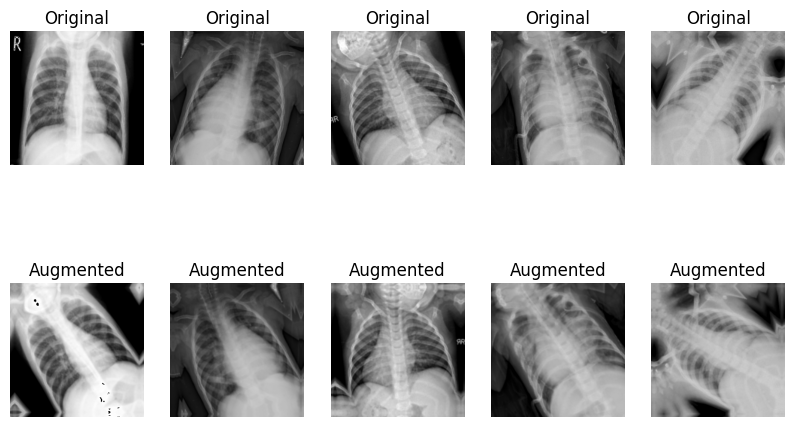

In [20]:
for images, labels in train_ds.take(1):
    sample_images = images[:5]  # pick 5 images to visualize


# Take one batch
for images, labels in train_ds.take(1):
    sample_images = images[:5]  # first 5 images

plt.figure(figsize=(10, 6))

for i in range(5):
    # Original image (rescale back to 0–255)
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow((sample_images[i].numpy() * 255).astype("uint8"))
    plt.title("Original")
    plt.axis("off")
    
    # Augmented image
    augmented_img = data_augmentation(tf.expand_dims(sample_images[i], 0), training=True)
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow((augmented_img[0].numpy() * 255).astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.show()




*Data augmentation* is the process of applying random transformations such as flipping, rotating, zooming, or adjusting brightness only on the training dataset.

*The purpose* is to artificially enlarge the dataset and introduce variations in the images. This does not change the labels (NORMAL vs. PNEUMONIA) it only changes the image appearance.

Why It Matters

When the dataset is small (especially with fewer NORMAL images), the model risks overfitting memorizing specific images rather than learning generalizable patterns.

By generating slightly different versions of existing images, data augmentation helps the model:

 1.Learn more robust features.

 2.Reduce overfitting.


# Model Building

In [40]:
inputs = layers.Input(shape=(224,224,3))

# Convolutional Block 1
x = layers.Conv2D(32,(3,3), padding='same' , activation='relu', kernel_regularizer= regularizers.l2(1e-4))(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Convolutional Block 2
x = layers.Conv2D(64, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Convolutional Block 3
x = layers.Conv2D(128, (3,3), padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

# Flatten and Dense layers
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x= layers.Dropout(0.4)(x)
outputs = layers.Dense(1, activation='sigmoid')(x) # binary classification

model = models.Model(inputs, outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,457 (49.36 MB)

 Trainable params: 12,939,009 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [41]:
# Compile the model

metrics = [
    "accuracy",
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR")
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=metrics
)


In [42]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_pr_auc",    
    mode="max", # maximize the PR AUC
    patience=5, # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau( # reduce learning rate when a metric has stopped improving
    monitor="val_loss",
    factor=0.5, 
    patience=3,
    verbose=1
)


In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 689s 4s/step - accuracy: 0.8246 - loss: 1.7910 - pr_auc: 0.9370 - precision: 0.9330 - recall: 0.8230 - roc_auc: 0.8675 - val_accuracy: 0.5000 - val_loss: 61.4998 - val_pr_auc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_roc_auc: 0.5000 - learning_rate: 0.0010
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 679s 4s/step - accuracy: 0.8681 - loss: 0.4345 - pr_auc: 0.9802 - precision: 0.9666 - recall: 0.8519 - roc_auc: 0.9486 - val_accuracy: 0.5000 - val_loss: 22.8053 - val_pr_auc: 0.5333 - val_precision: 0.5000 - val_recall: 1.0000 - val_roc_auc: 0.5625 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 686s 4s/step - accuracy: 0.8781 - loss: 0.3698 - pr_auc: 0.9859 - precision: 0.9753 - recall: 0.8575 - roc_auc: 0.9626 - val_accuracy: 0.6250 - val_loss: 1.4987 - val_pr_auc: 0.8433 - val_precision: 0.5714 - val_recall: 1.0000 - val_roc_auc: 0.8984 - learning_rate: 0.0010
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 680s 4s/step - accu

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=cnn_pneumonia_model.

In [55]:
# ✅ Recommended (Keras v3 format)
model.save("cnn_pneumonia_model.keras")

# # ✅ Legacy HDF5 format (still widely supported)
# model.save("cnn_pneumonia_model.h5")


#### Load Pretrained Model

In [15]:
from tensorflow.keras.models import load_model

# Load .keras format
model = load_model("cnn_pneumonia_model.keras")


# Evaluation

In [16]:
results = model.evaluate(test_ds)
print(dict(zip(model.metrics_names, results)))


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 787ms/step - accuracy: 0.8830 - loss: 0.4339 - pr_auc: 0.9662 - precision: 0.9490 - recall: 0.8590 - roc_auc: 0.9519
{'loss': 0.4339139759540558, 'compile_metrics': 0.8830128312110901}


# Evaluation 

#### Classification Report

In [26]:
# Get predictions and labels in one loop to avoid mismatch
y_true, y_pred, y_prob = [], [], []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0).ravel() # get probabilities ravel to flatten
    preds = (probs >= 0.5).astype(int)
    
    y_true.extend(labels.numpy().ravel())
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))


              precision    recall  f1-score   support

      NORMAL       0.80      0.92      0.86       234
   PNEUMONIA       0.95      0.86      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.89      0.88       624
weighted avg       0.89      0.88      0.88       624



#### confusion matrix

In [29]:
print(confusion_matrix(y_true, y_pred))

[[216  18]
 [ 55 335]]


**Classification Report**

1) Accuracy: 88%

2) NORMAL: Precision = 0.80, Recall = 0.92 → most healthy cases detected.

3) PNEUMONIA: Precision = 0.95, Recall = 0.86 → very few false alarms, but ~14% of pneumonia cases missed.

**Confusion Matrix**

1) TN = 216 (healthy correctly classified)

2) FP = 18 (healthy flagged as pneumonia)

3) FN = 55 (pneumonia missed → main risk)

4) TP = 335 (pneumonia correctly detected)

The model is strong overall, with excellent precision and good recall, but still misses some pneumonia cases.

### Training vs Validation Curves

### Testing our Model With a Single Image

In [33]:

IMG_SIZE = (224, 224)
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]  # same order as during training

def predict_xray(img_path, model, threshold=0.5):
    """
    Predicts if a chest X-ray is NORMAL or PNEUMONIA.

    Args:
        img_path (str): Path to the chest X-ray image.
        model: Trained keras model.
        threshold (float): Probability cutoff (default 0.5).
    """
    # Load and preprocess image
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict probability
    prob = model.predict(img_array)[0][0]

    # Apply threshold
    label = CLASS_NAMES[1] if prob >= threshold else CLASS_NAMES[0]

    # Show result
    print(f"Prediction: {label} (Pneumonia probability={prob:.4f})")

    # Plot image with label
    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.title(f"Predicted: {label} ({prob:.2%})")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Prediction: NORMAL (Pneumonia probability=0.0138)


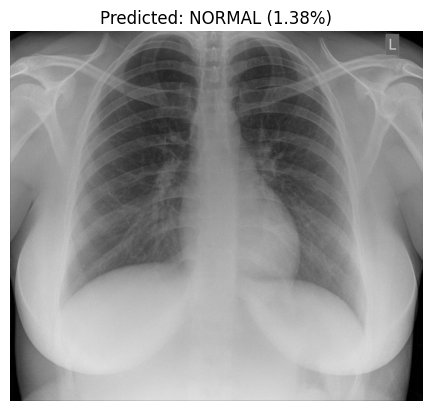

In [34]:
# Example: test an image
predict_xray(
    r"502185e27fd4aadd6f1bcc65dd5738d4ed8da4aaec6e901cf5d07fc62768cdf3_big_gallery.jpeg", 
    model, 
    threshold=0.5
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Prediction: PNEUMONIA (Pneumonia probability=0.8333)


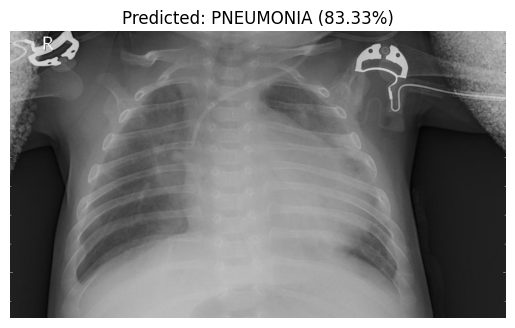

In [36]:
# Example: test an image
predict_xray(
    r"C:\Users\user\Desktop\ChestXrayproject\person1_virus_12.jpeg", 
    model, 
    threshold=0.5
)


# Conclusion

In this project, I developed a Convolutional Neural Network (CNN) to classify chest X-ray images as NORMAL or PNEUMONIA. Through preprocessing, data augmentation, and class balancing, the model achieved 88% accuracy on the test set, with high precision (95%) and good recall (86%) for pneumonia detection.

The classification report and confusion matrix show that while the model is highly reliable in minimizing false alarms, it still misses some pneumonia cases (~14%). This highlights the tradeoff between precision and recall in medical AI applications.

Overall, the project demonstrates that deep learning can be an effective tool for assisting pneumonia diagnosis from X-rays. With further improvements such as threshold tuning, transfer learning (e.g., ResNet, EfficientNet), and more balanced datasets, the model could be made even more robust for realworld clinical use.

**Done By : Rami Assaf**

In [38]:
pytest -v


NameError: name 'pytest' is not defined